In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import tensorflow as tf
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import * 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/376_project/_labels.csv', dtype=str)
data.id = data.id + '.tif'
print(data.shape)
data.head

(220025, 2)


<bound method NDFrame.head of                                                   id label
0       f38a6374c348f90b587e046aac6079959adf3835.tif     0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2       755db6279dae599ebb4d39a9123cce439965282d.tif     0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4       068aba587a4950175d04c680d38943fd488d6a9d.tif     0
...                                              ...   ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0
220021  d4b854fe38b07fe2831ad73892b3cec877689576.tif     1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif     0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb.tif     1

[220025 rows x 2 columns]>

In [4]:
train, val_test = train_test_split(data, train_size=0.9)
val, test = train_test_split(val_test, train_size=0.5)
print(train.shape)
print(val.shape)
print(test.shape)

(198022, 2)
(11001, 2)
(11002, 2)


In [5]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.3,
                                   dtype=tf.float32)
validation_datagen = ImageDataGenerator(rescale=1/255,
                                   dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1/255,
                                   dtype=tf.float32)

In [6]:
train_path = '/content/drive/MyDrive/376_project/data_large'

In [ ]:
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

valid_loader = validation_datagen.flow_from_dataframe(
    dataframe = val,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

test_loader = train_datagen.flow_from_dataframe(
    dataframe = test,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/376_project/base/model')
loss, accuracy, auc_1 = model.evaluate(test_loader)
print(accuracy)

6/6 [==============================] - 155s 29s/step - loss: 0.6177 - accuracy: 0.7337 - auc_1: 0.8063
0.7336956262588501


In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(96,96,3), 
    include_top=False, 
    weights='imagenet'
)

base_model.trainable = False

np.random.seed(1)
tf.random.set_seed(1)

model = Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 batch_normalization_12 (Bat  (None, 3, 3, 2048)       8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_18 (Dense)            (None, 8)                 147464    
                                                                 
 dropout_12 (Dropout)        (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 4)                 36        
                                                      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.AUC()])
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/376_project/actualresnet96/',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
h1 = model.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 10,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
95/95 [==============================] - 2030s 21s/step - loss: 0.7008 - accuracy: 0.5614 - auc_1: 0.5996 - val_loss: 0.6837 - val_accuracy: 0.5687 - val_auc_1: 0.5687
Epoch 2/10
95/95 [==============================] - 24s 251ms/step - loss: 0.6437 - accuracy: 0.5943 - auc_1: 0.6576 - val_loss: 0.6805 - val_accuracy: 0.5687 - val_auc_1: 0.6250
Epoch 3/10
95/95 [==============================] - 23s 240ms/step - loss: 0.6280 - accuracy: 0.6112 - auc_1: 0.6808 - val_loss: 0.6663 - val_accuracy: 0.5687 - val_auc_1: 0.6517
Epoch 4/10
95/95 [==============================] - 23s 247ms/step - loss: 0.6252 - accuracy: 0.6130 - auc_1: 0.6878 - val_loss: 0.6434 - val_accuracy: 0.5687 - val_auc_1: 0.6856
Epoch 5/10
95/95 [==============================] - 23s 246ms/step - loss: 0.6264 - accuracy: 0.6171 - auc_1: 0.6841 - val_loss: 0.6220 - val_accuracy: 0.5687 - val_auc_1: 0.6853
Epoch 6/10
95/95 [==============================] - 23s 241ms/step - loss: 0.6259 - accuracy: 0.5971 - au

In [ ]:
model.save('/content/drive/MyDrive/376_project/actualresnet96/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/376_project/actualresnet96/model/assets


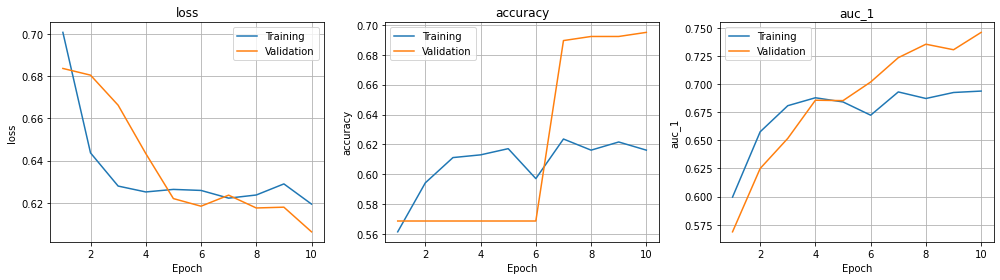

In [ ]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()


history = merge_history([h1])
vis_training(history)

In [ ]:
loss, accuracy, auc_1 = model.evaluate(test_loader)
print(accuracy)

6/6 [==============================] - 2s 223ms/step - loss: 0.6057 - accuracy: 0.6984 - auc_1: 0.7566
0.698369562625885
